# Compare CAMx to TEMPO NO2, HCHO and FNR (HCHO/NO2)
## read paired output files and plot

In [1]:
# This part is only needed if the script fails because of modules not found 
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('/glade/campaign/acom/acom-weather/pfister/ANALYSIS/MELODIES/monetio')
sys.path.append('/glade/campaign/acom/acom-weather/pfister/ANALYSIS/MELODIES/monet')
sys.path.append('/glade/campaign/acom/acom-weather/pfister/ANALYSIS/MELODIES/MELODIES-MONET/')

from melodies_monet import driver
driver.__file__
import melodies_monet as mm
import monetio as mio
print(mio.__file__)
import monet
print(monet.__file__)
from melodies_monet import driver
import numpy as np

/glade/work/pfister/conda-envs/melodies-monet/lib/python3.11/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/glade/campaign/acom/acom-weather/pfister/ANALYSIS/MELODIES/monetio/monetio/__init__.py
/glade/campaign/acom/acom-weather/pfister/ANALYSIS/MELODIES/monet/monet/__init__.py


In [2]:
# READ THE control yaml file
import xarray as xr
an = driver.analysis()
an.control = 'control_camx_tempo_read_paired_data.yaml'
an.read_control()

In [3]:
# read a paired outputfile 
an.read_analysis()

Reading: ./output/tempo/2024-07-20_tempo_l2_no2_CAMX.nc4
Reading: ./output/tempo/2024-07-20_tempo_l2_hcho_CAMX.nc4


In [4]:
# calculate FNR from NO2 and HCHO paired output
# only calculate FNR for pixels with NO2 > 1e15 molec/cm2
an.obs["tempo_l2_FNR"] = driver.observation()
an.obs["tempo_l2_FNR"].sat_type = "tempo_l2"
an.obs["tempo_l2_FNR"].variable_dict = {"tempo_l2_FNR": {"ylabel_plot": "FNR"}}

models = ["CAMX"]
no2 = ["NO2"]
hcho = ["FORM"]

for pair in an.paired.keys():
    an.paired[pair].obj = an.paired[pair].obj.sel(time=(an.paired[pair].obj['time'].dt.hour > 4))

for no2_m, hcho_m, model in zip(no2, hcho, models):
    ratio_FNR = xr.Dataset()
    ratio_FNR["tempo_l2_FNR"] = (
        an.paired[f"tempo_l2_hcho_{model}"].obj["vertical_column"]
        / an.paired[f"tempo_l2_no2_{model}"].obj["vertical_column_troposphere"]
    ).where(an.paired[f"tempo_l2_no2_{model}"].obj["vertical_column_troposphere"] > 1e15)
    ratio_FNR[f"{model}_FNR"] = (
        an.paired[f"tempo_l2_hcho_{model}"].obj[hcho_m]
        / an.paired[f"tempo_l2_no2_{model}"].obj[no2_m]
    ).where(an.paired[f"tempo_l2_no2_{model}"].obj[no2_m] > 1e15)   

    p = driver.pair()
    p.type = "sat_swath_clm"
    p.obs = "tempo_l2_FNR"
    p.model = f"{model}"
    p.model_vars = [f"{model}_FNR"]
    p.obs_vars = ["tempo_l2_FNR"]
    p.obj = ratio_FNR
    p.filename = f"tempo_l2_FNR_{model}.nc"
    an.paired[f"tempo_l2_FNR_{model}"] = p

{'color': 'k', 'linestyle': '-', 'marker': '*', 'linewidth': 2.0, 'markersize': 10.0, 'label': 'tempo_l2_no2', 'fontsize': 14.4}
{'color': 'k', 'linestyle': '-', 'marker': '*', 'linewidth': 2.0, 'markersize': 10.0, 'label': 'tempo_l2_hcho', 'fontsize': 14.4}
{'color': 'k', 'linestyle': '-', 'marker': '*', 'linewidth': 2.0, 'markersize': 10.0, 'label': 'tempo_l2_FNR', 'fontsize': 14.4}


/glade/work/pfister/conda-envs/melodies-monet/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/glade/work/pfister/conda-envs/melodies-monet/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/glade/work/pfister/conda-envs/melodies-monet/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/glade/work/pfister/conda-envs/melodies-monet/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


0 1e+16
0 1e+16
0 1e+16
0 1e+16
0 6
0 6
Base standard deviation:  1.76e+15
Reference std: 1
Base standard deviation:  6.39e+15
Reference std: 1
Base standard deviation:  2.77
Reference std: 1


/glade/campaign/acom/acom-weather/pfister/ANALYSIS/MELODIES/MELODIES-MONET/melodies_monet/stats/proc_stats.py:241: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=table_kwargs['figsize'])


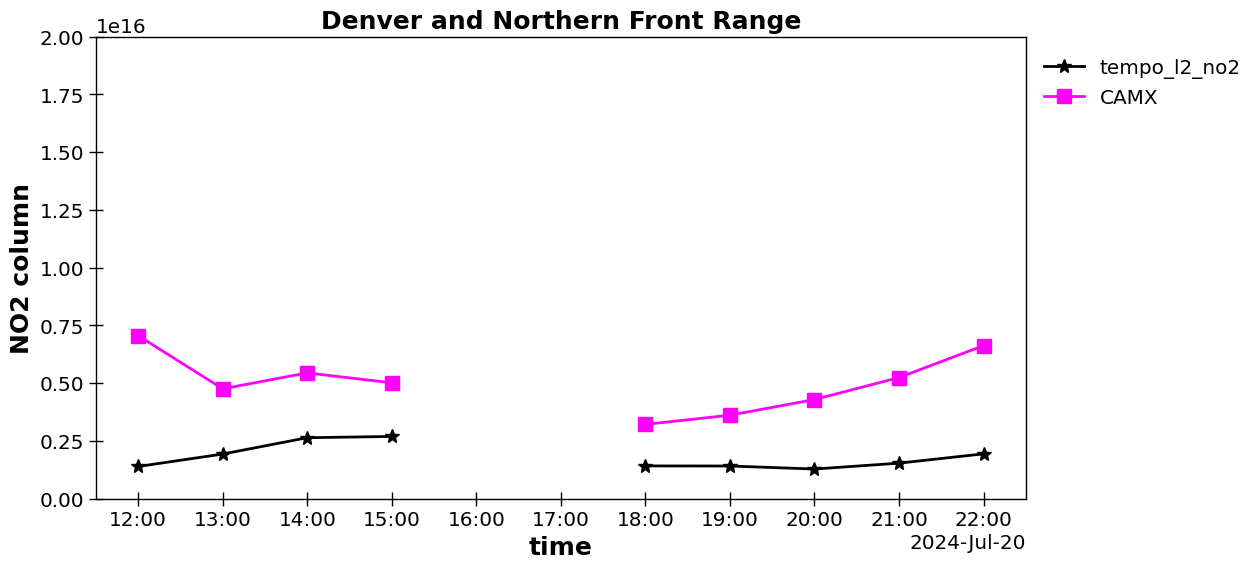

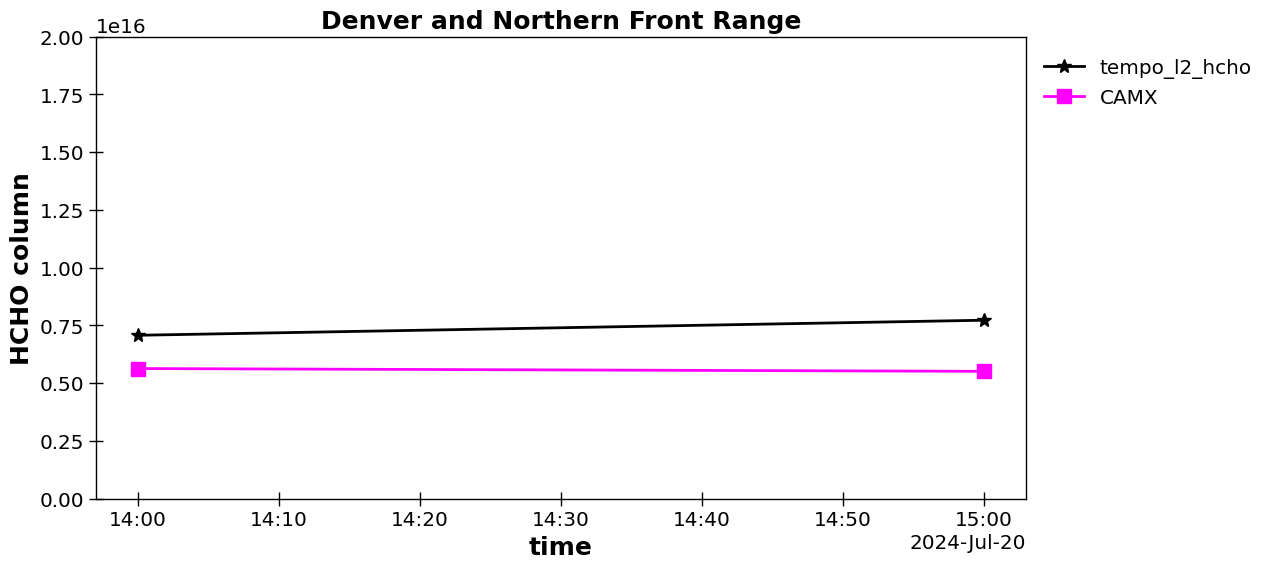

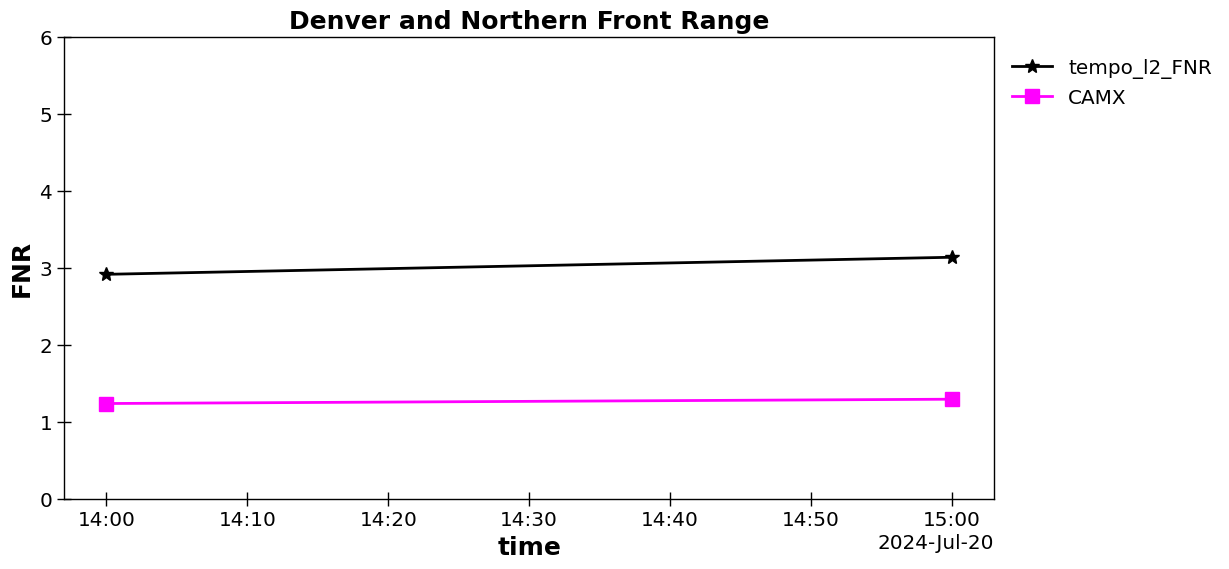

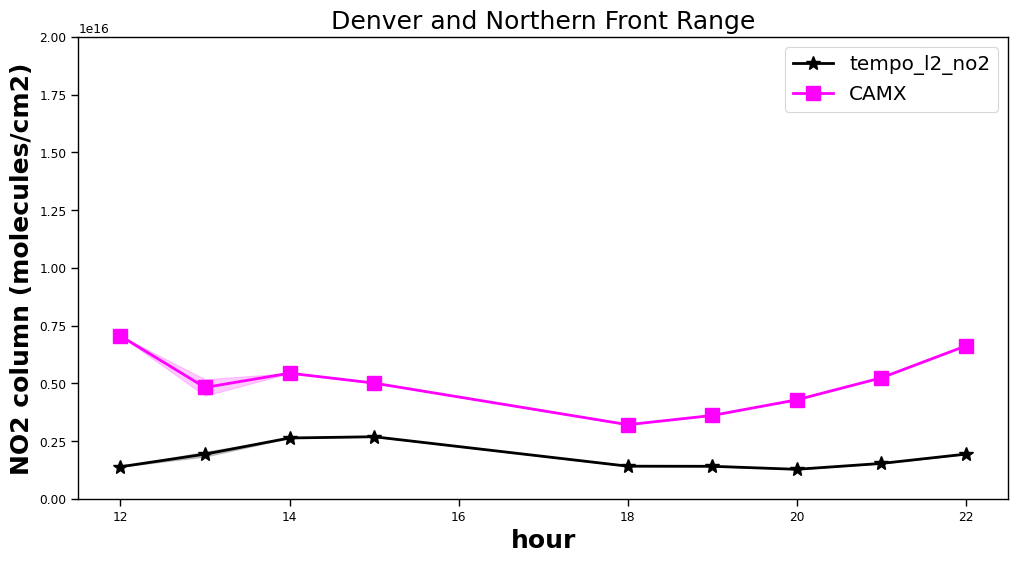

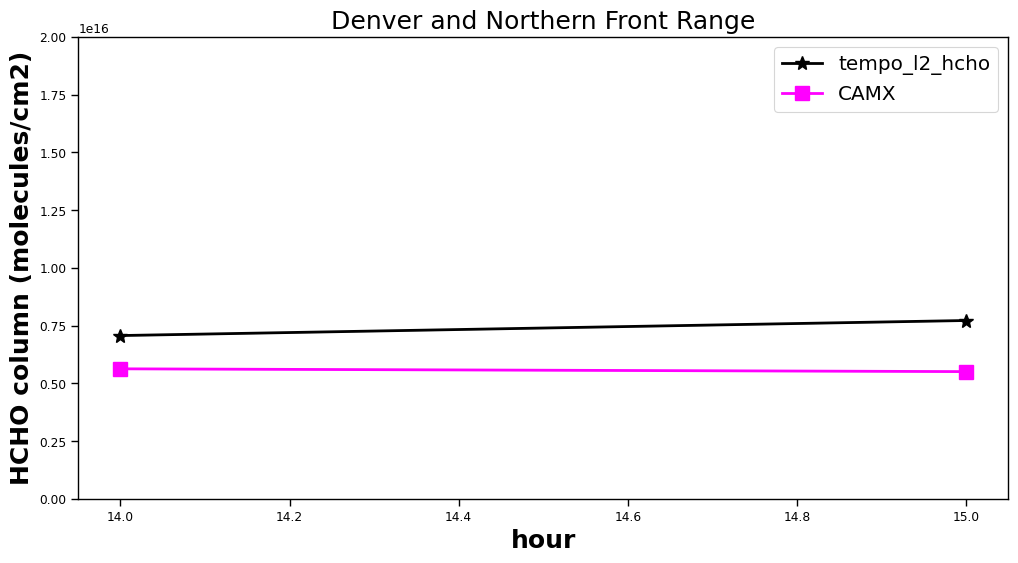

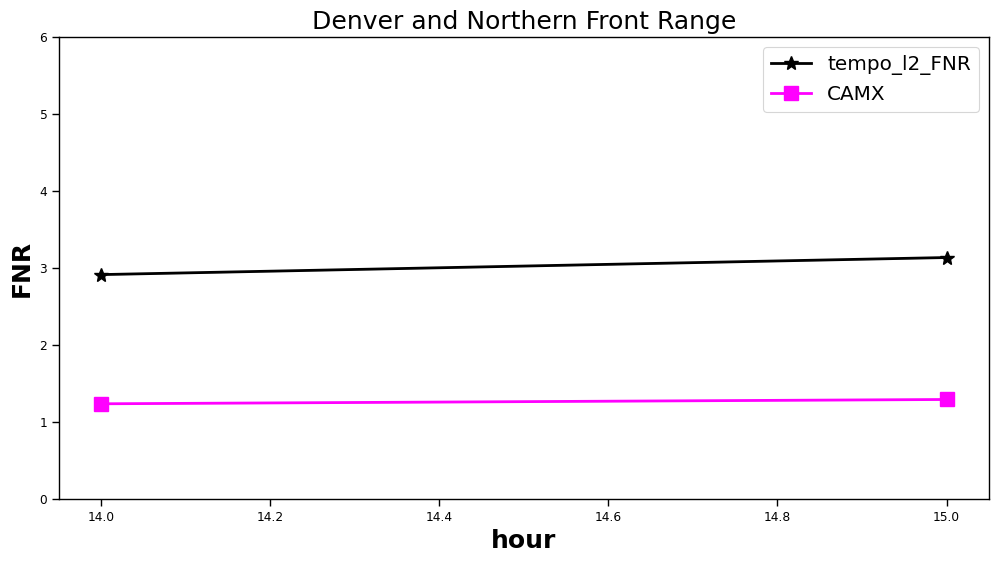

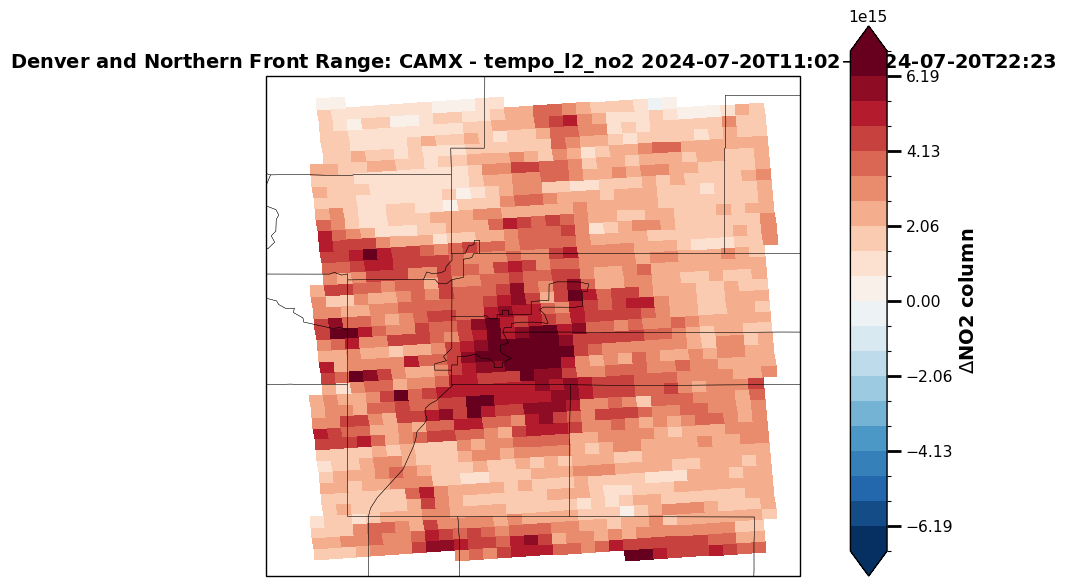

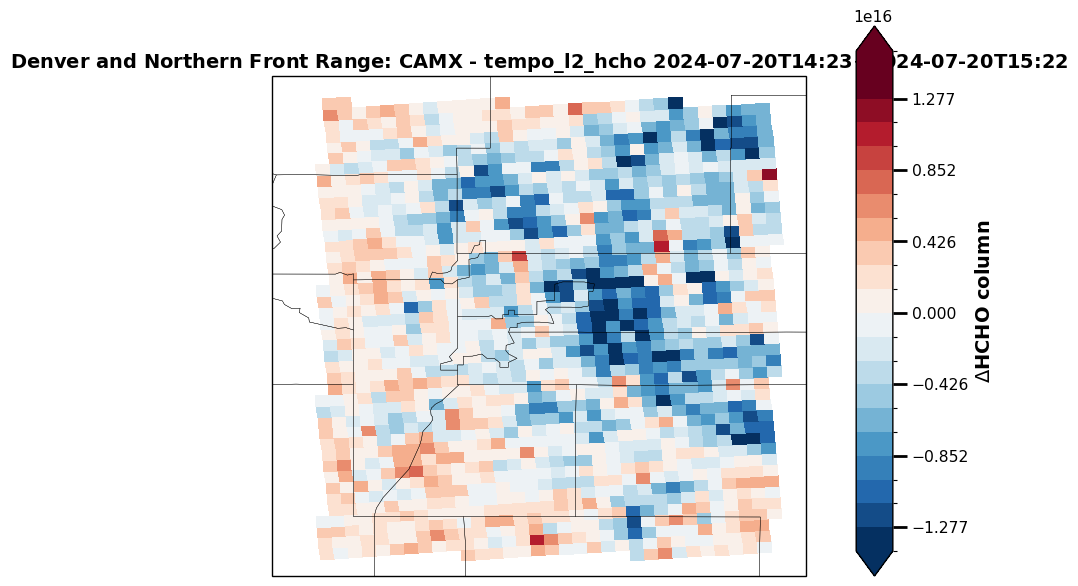

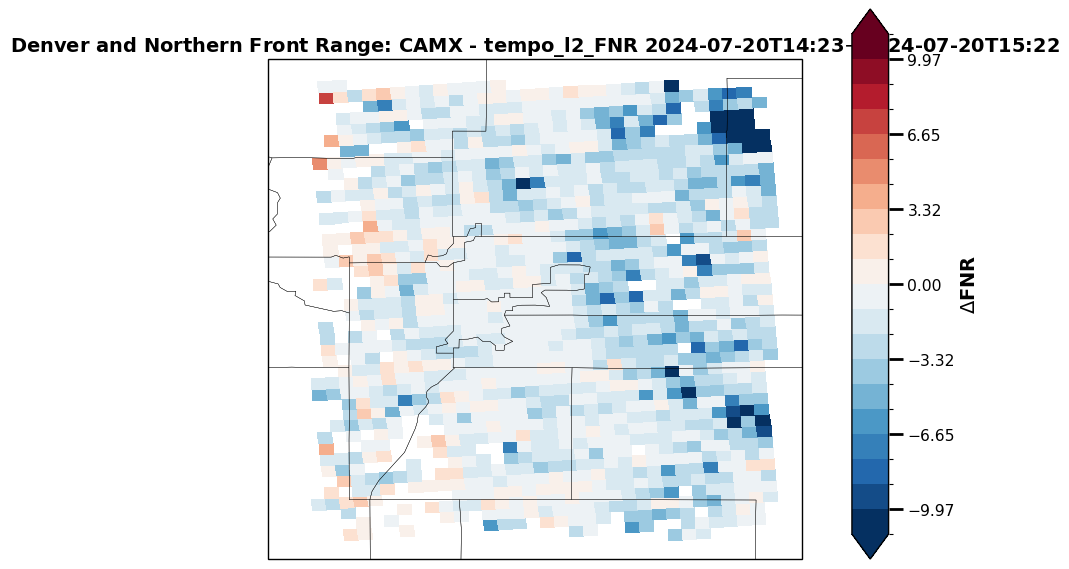

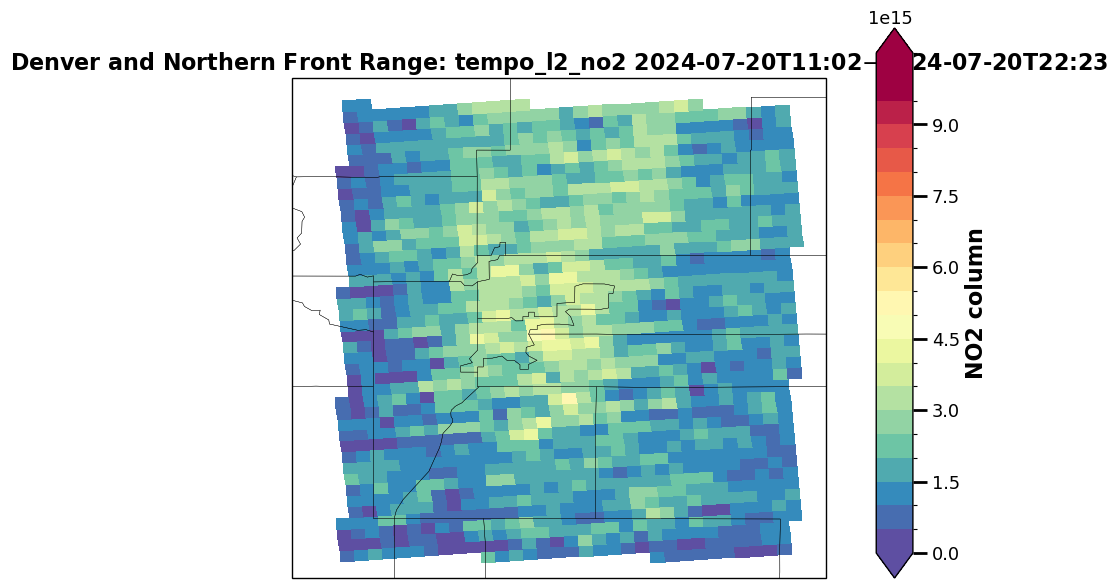

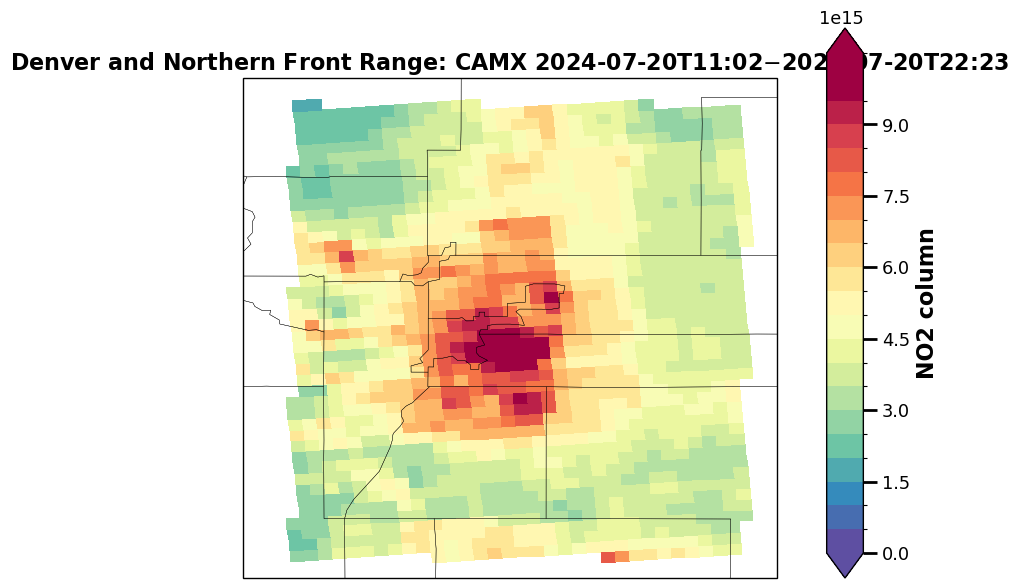

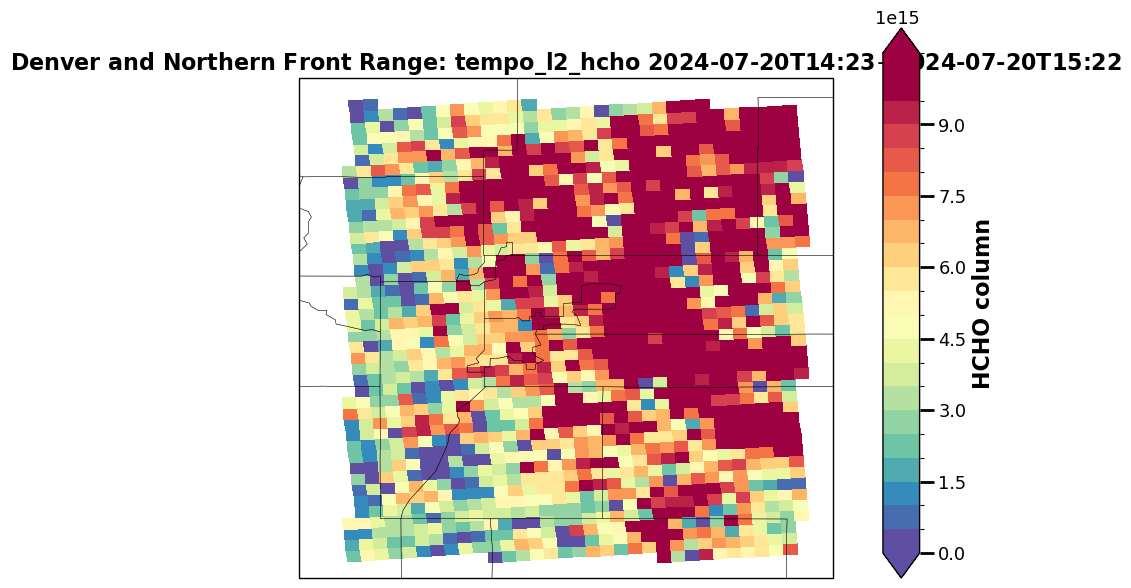

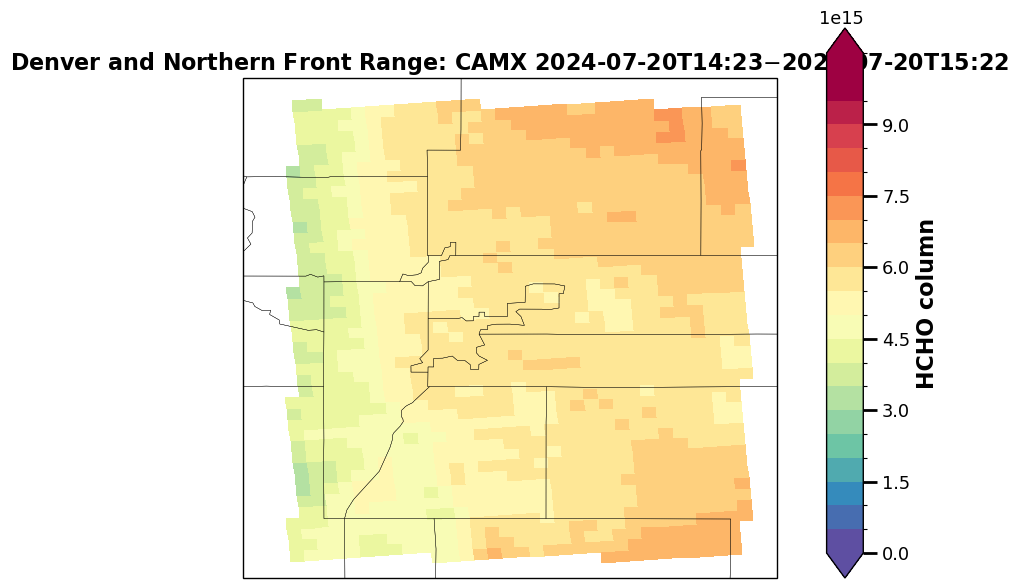

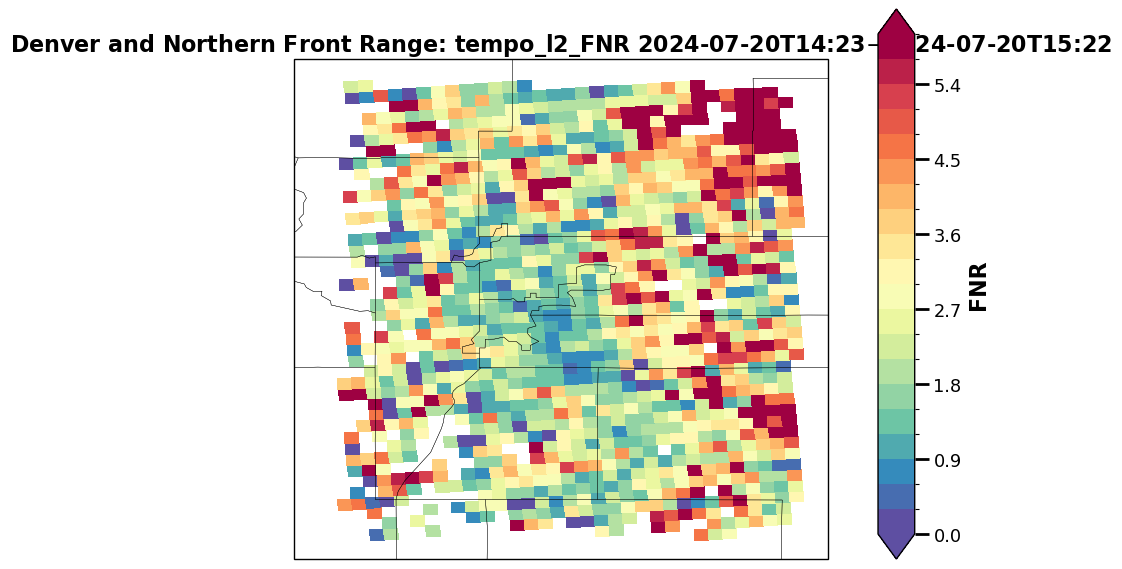

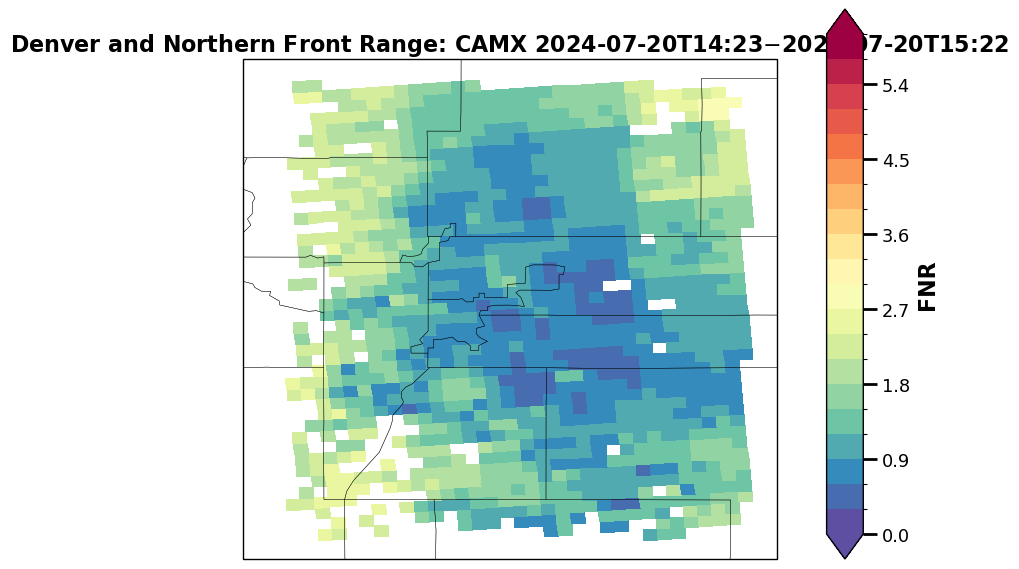

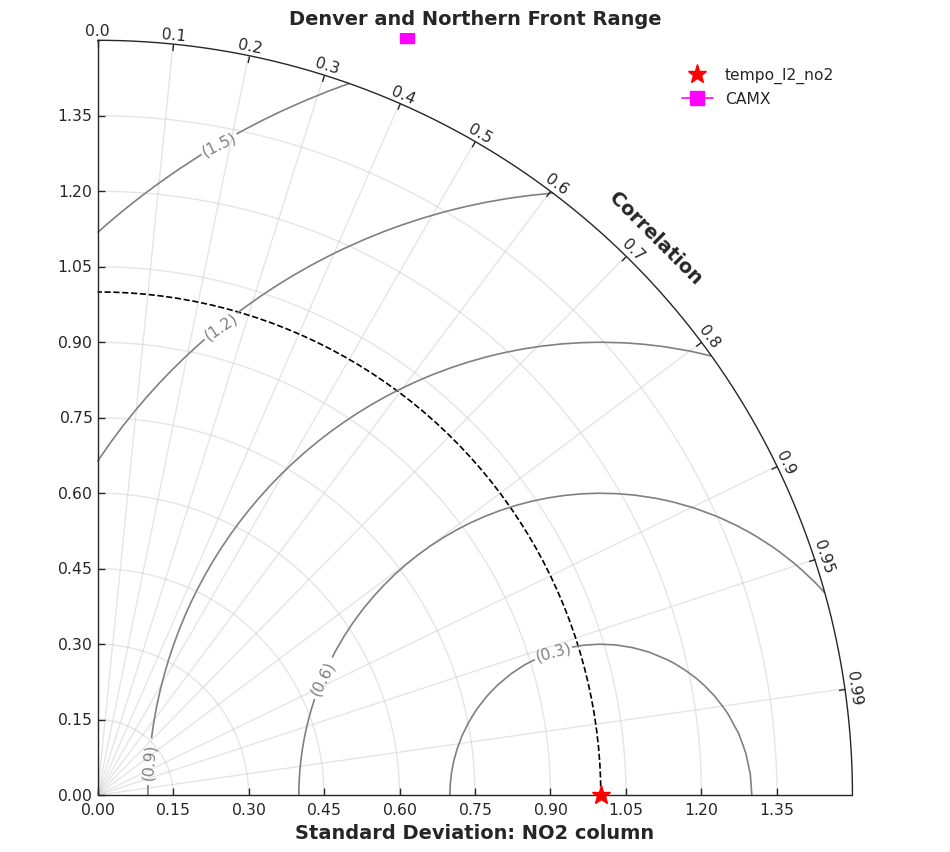

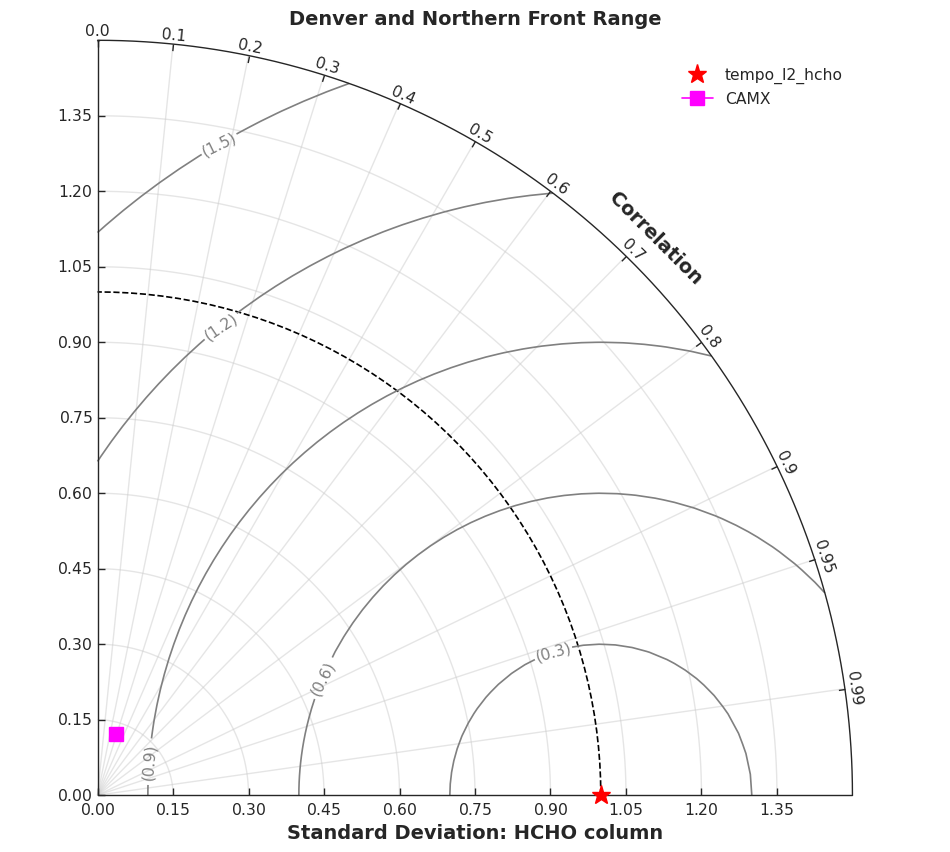

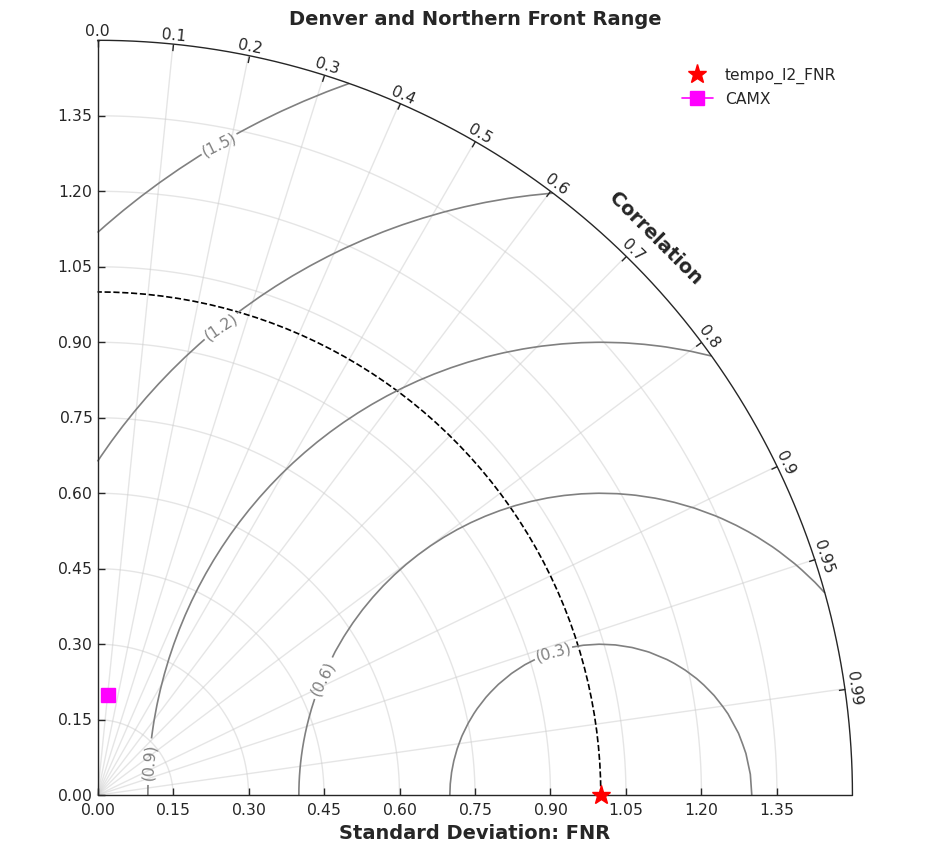

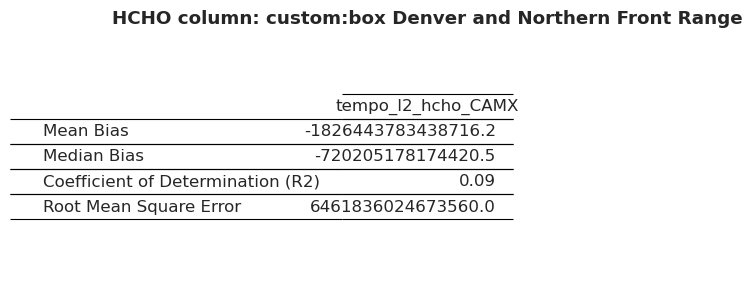

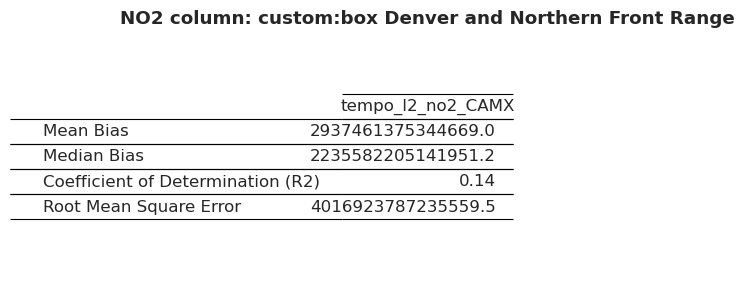

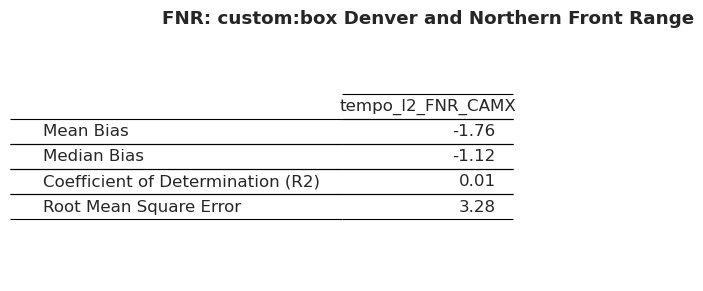

In [5]:
# plotting and statistics
an.plotting()
an.stats()